In [4]:
import os
from skimage.io import imread, imsave
import numpy as np
from skimage.filters import gaussian
import matplotlib.pyplot as plt

In [5]:
#path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#/Ti scope/2023_11_28/2023_11_28_10x_1.0x_pAAA_Ti_Pos6.ome.tif

In [6]:
#scope_name = 'Ti scope'
scope_name = 'Tweez scope'
path_scope = os.path.join(path_ext, scope_name)
exp_date = '2023_12_08'
df_date = '2023-12-08'
path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
pos = 0
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
vector = 'pLPT20&41'

In [17]:
"""
rfp_chn = 0
yfp_chn = 1
cfp_chn = 2
ph_chn = 3
fluo_chns = 3
"""
yfp_chn = 0
cfp_chn = 1
ph_chn = 2
fluo_chns = 2

In [18]:
fname = f'{exp_date}_10x_1.0x_{vector}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname

'2023_12_08_10x_1.0x_pLPT20&41_TiTweez_Pos0.ome.tif'

In [19]:
path_im = os.path.join(path, fname)
path_results = os.path.join(path, folder_results, f"pos{pos}")

In [20]:
#fname = '10x_1.0x_pAAA_-6_1_MMStack_Pos6.ome.tif'
im_all = imread(path_im)
#im_all = im_all.transpose([0,2,3,1])
im_all = im_all[:,:,:,:ph_chn]
nt,nx,ny,nc = im_all.shape
print(im_all.shape)

(406, 1024, 1024, 2)


In [21]:
bg = np.zeros((nc,))
for c in range(nc):
    bg[c] = im_all[0,:100,:100,c].mean()

In [22]:
nc

2

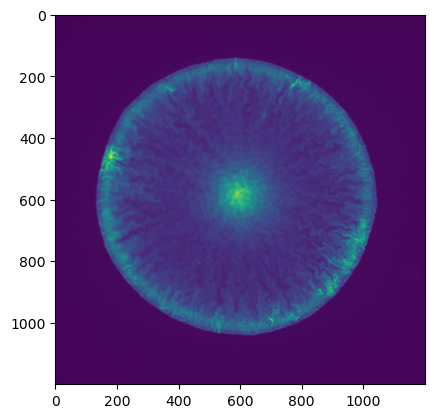

In [13]:
plt.imshow(im_all[100,:,:,1])

In [12]:
edt = np.load(os.path.join(path_results,'edt.npy'))
edt = edt[:,:,:]

In [13]:
edt.shape

(406, 1024, 1024)

In [21]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
w = int(w//2) * 2
h = maxy - miny
h = int(h//2) * 2

print(w,h)
pad = 32

crop_im_all = np.zeros((nt,w+2*pad,h+2*pad,nc))
crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
print(crop_im_all.shape)
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    cim = im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, :]
    crop_im_all[t,:,:,:] = cim
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]

968 990
(216, 1032, 1054, 4)
(216, 1032, 1054)


In [23]:
h

990

In [25]:
im_all = crop_im_all
edt = crop_edt

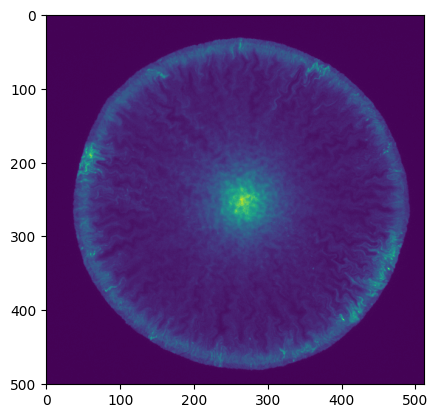

In [ ]:
plt.imshow(im_all[100,:,:,1])

In [10]:
nt,nx,ny,nc = im_all.shape

normed_im = np.zeros((nt,nx,ny,nc))
normed_im[:,:,:,3] = im_all[:,:,:,0]
for t in range(nt):
    tedt = edt[t,:,:]
    for c in range(nc):
        tcim = im_all[t,:,:,c]
        mean_tcim = tcim[tedt>0].mean()
        std_tcim = tcim[tedt>0].std()
        min_tcim = tcim[tedt>0].min()
        max_tcim = tcim[tedt>0].max()
        #ntcim = (tcim - mean_tcim)/std_tcim
        ntcim = (tcim - min_tcim) / (max_tcim - min_tcim)
        ntcim[tedt==0] = 0 # np.nan
        normed_im[t,:,:,c] = ntcim

vmin = np.nanmin(normed_im)
vmax = np.nanmax(normed_im)
for t in range(nt): #  [0,31,61,92,123,154,184,215]:
    plt.figure(figsize=(12,12))
    #for c in range(nc):
    #    plt.subplot(1, 3, c + 1)
    #    plt.imshow(normed_im[t,:,:,c], vmin=vmin, vmax=vmax)
    #    plt.colorbar()
    #    plt.xticks([])
    #    plt.yticks([])
    plt.imshow(normed_im[t,:,:,0])
    plt.imshow(normed_im[t,:,:,1:])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig('normed_channels_%04d.png'%t)
    plt.close()

NameError: name 'edt' is not defined

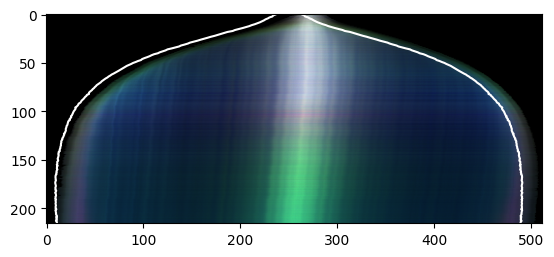

In [24]:
cx = nx // 2
cy = ny // 2
plt.imshow(normed_im[:,cx-16:cx+16,:,1:].mean(axis=1))
radius = edt.max(axis=(1,2))
plt.plot(cx + radius/2, np.arange(nt), 'w')
plt.plot(cx - radius/2, np.arange(nt), 'w')

In [23]:
nt,nx,ny,nc = im_all.shape
nr = 64
rw = 16
# dont construct the kymo from the edge, so it starts from rw to edt.max
# the edge is not that reliable because of the mask, niose numbers at the edge
rs = np.linspace(rw, edt.max(), nr)
kymo = np.zeros((nt,nr,nc)) + np.nan
#nkymo = np.zeros((nt,nr,3)) + np.nan
for t in range(nt):
    for c in range(nc):
        for ri in range(nr):
            tedt = edt[t,:,:]
            idx = np.abs(tedt - rs[ri]) < rw
            if np.sum(idx)>0:
                ntcim = im_all[t,:,:,c]
                kymo[t,ri,c] = np.nanmean(ntcim[idx])
                #ntcnim = normed_im[t,:,:,1+c]
                #nkymo[t,ri,c] = np.nanmean(ntcnim[idx])

In [24]:
def map_func(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

from skimage.transform import warp
for c in range(3):
    wnkymo[:,:,c] = warp(nkymo[:,:,c], map_func, {'edt':edt, 'rs':rs})
wnkymo[np.isnan(nkymo)] = np.nan

NameError: name 'nkymo' is not defined

(216, 64, 3)


Text(0.5, 1.0, 'Normalized fluorescence')

/Users/timrudge/opt/anaconda3/envs/infotracking/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


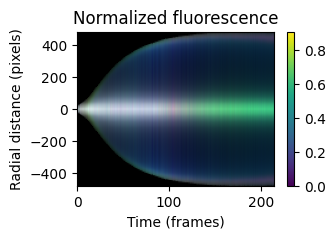

In [34]:
print(wnkymo.shape)
plt.figure(figsize=(7,2))
plt.subplot(1, 2, 1)
plt.imshow(np.hstack([wnkymo[:,::-1,:],wnkymo[:,:,:]]).transpose([1,0,2]), 
           aspect='auto', 
           extent=[0,215,-edt.max(),edt.max()])
plt.colorbar()
plt.xlabel('Time (frames)')
plt.ylabel('Radial distance (pixels)')
plt.title('Normalized fluorescence')

In [28]:
kymo.shape

(406, 64, 2)

In [ ]:
kymo2 = np.zeros

In [29]:
kymo_rho.shape

(406, 64)

(406, 64)


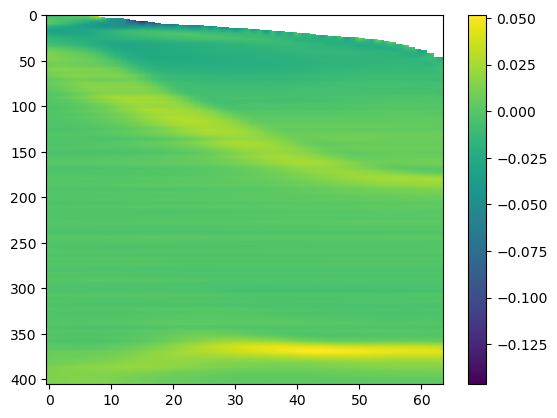

In [40]:
ph_chns = 2

## rate of change of the log of the ratio btween two channels, for example r/c
from scipy.signal import savgol_filter
if ph_chns == 3:
    kymo_rho = np.stack([kymo[:,:,0] / kymo[:,:,2], kymo[:,:,1] / kymo[:,:,2]], axis=2)
    cs = 2
else:
    #kymo_rho = np.stack(kymo[:,:,0] / kymo[:,:,1], axis=1)
    kymo_rho = kymo[:,:,0] / kymo[:,:,1]
    cs = 1
print(kymo_rho.shape)


lkymo_rho = np.log(kymo_rho)
dlkymo_rho = np.zeros_like(lkymo_rho) + np.nan

if ph_chns == 3:

    for r in range(nr):
        for c in range(cs):
            idx = ~np.isnan(lkymo_rho[:,r,c])
            dlkymo_rho[idx,r,c] = savgol_filter(lkymo_rho[idx,r,c], 21, 3, deriv=1, axis=0)
        
    plt.subplot(1, 2, 1)
    plt.imshow(dlkymo_rho[:,:,0], aspect='auto')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(dlkymo_rho[:,:,1], aspect='auto')
    plt.colorbar()
    
else:
    for r in range(nr):
        #for c in range(cs):
        idx = ~np.isnan(lkymo_rho[:,r])
        dlkymo_rho[idx,r] = savgol_filter(lkymo_rho[idx,r], 21, 3, deriv=1, axis=0)
    plt.imshow(dlkymo_rho[:,:], aspect='auto')
    plt.colorbar()


In [41]:
def map_func(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

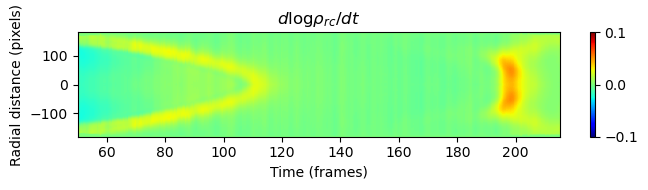

In [42]:
from skimage.transform import warp
wdlkymo_rho = np.zeros_like(dlkymo_rho)

if ph_chns == 3:
    for c in range(ph_chns):
        wdlkymo_rho[:,:,c] = warp(dlkymo_rho[:,:,c], map_func, {'edt':edt, 'rs':rs})
    wdlkymo_rho[np.isnan(dlkymo_rho)] = np.nan
    
    plt.figure(figsize=(7,2))
    plt.subplot(1, 2, 1)
    plt.imshow(np.hstack([wdlkymo_rho[50:,::-1,0],wdlkymo_rho[50:,:,0]]).transpose(), 
               aspect='auto', 
               extent=[50,215,-edt.max(),edt.max()],
               vmin=-0.1, vmax=0.1,
               cmap='jet')
    plt.colorbar()
    plt.xlabel('Time (frames)')
    plt.ylabel('Radial distance (pixels)')
    plt.title('$d\mathrm{log}\\rho_{rc}/dt$')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.hstack([wdlkymo_rho[50:,::-1,1],wdlkymo_rho[50:,:,1]]).transpose(), 
               aspect='auto', 
               extent=[50,215,-edt.max(),edt.max()],
               vmin=-0.1, vmax=0.1,
               cmap='jet')
    plt.colorbar()
    plt.xlabel('Time (frames)')
    plt.ylabel('Radial distance (pixels)')
    plt.title('$d\mathrm{log}\\rho_{yc}/dt$')
    
    plt.tight_layout()
    plt.savefig('wdlkymo_rho.png', dpi=300)
else:
    wdlkymo_rho[:,:] = warp(dlkymo_rho[:,:], map_func, {'edt':edt, 'rs':rs})
    wdlkymo_rho[np.isnan(dlkymo_rho)] = np.nan
    
    plt.figure(figsize=(7,2))
    #plt.subplot(1, 2, 1)
    plt.imshow(np.hstack([wdlkymo_rho[50:,::-1],wdlkymo_rho[50:,:]]).transpose(), 
               aspect='auto', 
               extent=[50,215,-edt.max(),edt.max()],
               vmin=-0.1, vmax=0.1,
               cmap='jet')
    plt.colorbar()
    plt.xlabel('Time (frames)')
    plt.ylabel('Radial distance (pixels)')
    plt.title('$d\mathrm{log}\\rho_{rc}/dt$')
    """
    plt.subplot(1, 2, 2)
    plt.imshow(np.hstack([wdlkymo_rho[50:,::-1,1],wdlkymo_rho[50:,:,1]]).transpose(), 
               aspect='auto', 
               extent=[50,215,-edt.max(),edt.max()],
               vmin=-0.1, vmax=0.1,
               cmap='jet')
    plt.colorbar()
    plt.xlabel('Time (frames)')
    plt.ylabel('Radial distance (pixels)')
    plt.title('$d\mathrm{log}\\rho_{yc}/dt$')
    """
    plt.tight_layout()
   # plt.savefig('wdlkymo_rho.png', dpi=300)

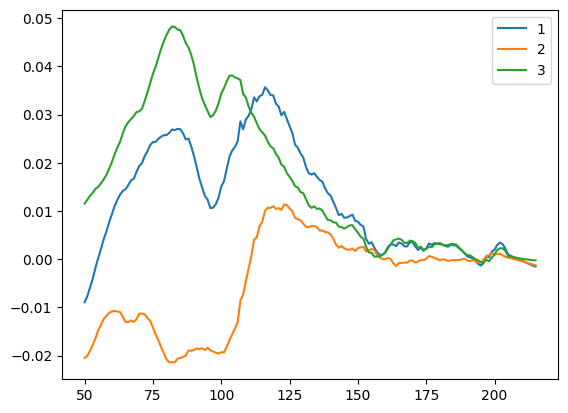

In [107]:
## warped transformed thing
## rate of change of log ratio
## has two peaks
## phase offset and period of those two peaks
plt.plot(np.arange(50, 216), wdlkymo_rho[50:,24,:])
plt.plot(np.arange(50, 216), wdlkymo_rho[50:,24,0] - wdlkymo_rho[50:,24,1])
#plt.legend(rs[np.arange(20,28)])
plt.legend([1,2,3])

array([[143., 163., 249.],
       [192., 171., 229.],
       [192., 176., 202.]])

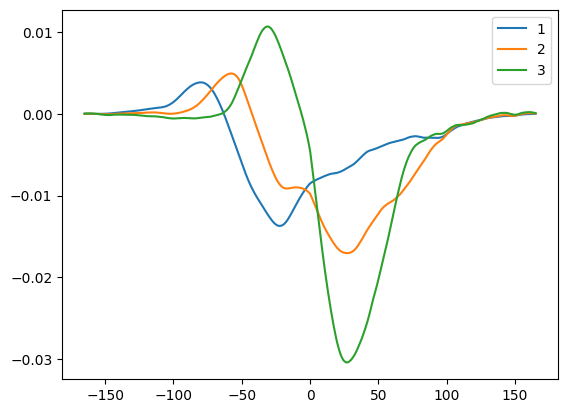

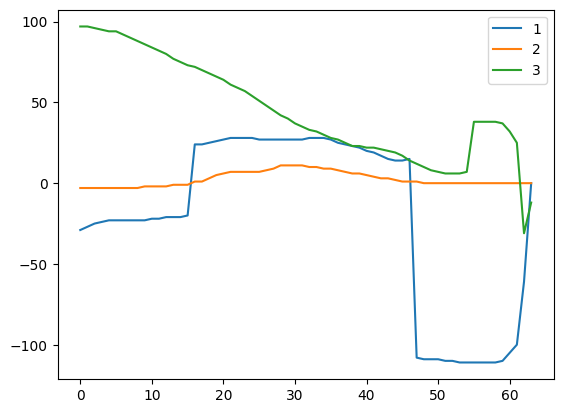

In [72]:
# phase offset as a function of ratios
## cannot make a lot of sense out of it
from scipy.signal import correlate, correlation_lags
cc = np.zeros((331,nr,3))
peaks = np.zeros((nr,3))
for r in range(nr):
    cc[:,r,0] = correlate(wdlkymo_rho[50:,r,0], wdlkymo_rho[50:,r,1], 'full')
    peaks[r,0] = np.argmin(cc[:,r,0])
    cc[:,r,1] = correlate(wdlkymo_rho[50:,r,0], wdlkymo_rho[50:,r,1] - wdlkymo_rho[50:,r,0], 'full')
    peaks[r,1] = np.argmin(cc[:,r,1])
    cc[:,r,2] = correlate(wdlkymo_rho[50:,r,1], wdlkymo_rho[50:,r,1] - wdlkymo_rho[50:,r,0], 'full')
    peaks[r,2] = np.argmin(cc[:,r,2])
#plt.imshow(cc[:,:,0])
nnt = wdlkymo_rho.shape[0] - 50
lags = correlation_lags(nnt, nnt)

plt.figure()
plt.plot(lags, cc[:,10,0])
plt.plot(lags, cc[:,20,0])
plt.plot(lags, cc[:,30,0])
plt.legend([1,2,3])

plt.figure()
plt.plot(lags[peaks.astype(int)])
plt.legend([1,2,3])

peaks[[10,20,30]]

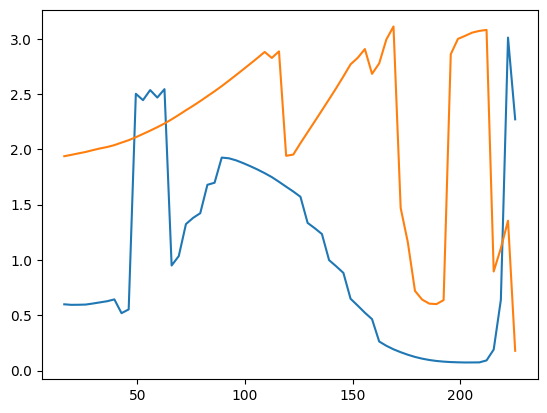

In [106]:
## trying to use fft to get the frequency of the oscillations
from numpy.fft import fft, fftshift, fftfreq

Ts = np.zeros((nr,2))
phases = np.zeros((nr,2))
for r in range(nr):
    for c in range(2):
        s = wdlkymo_rho[50:,r,c]
        ft = fft(s - s.mean(), len(s)*16)
        ps = (ft * ft.conjugate()).real
        freqs = fftfreq(len(ft))
        idx = (freqs<0.05) * (freqs>0)
        #plt.plot(freqs[idx], ps[idx], '.')

        pkidx = np.argmax(ps)
        f0 = freqs[pkidx]
        T = abs(1/f0)
        Ts[r,c] = T

        phase = np.angle(ft[pkidx])
        #if phase<0:
        #    phase = np.pi + phase
        phases[r,c] = abs(phase)
plt.plot(rs, phases)

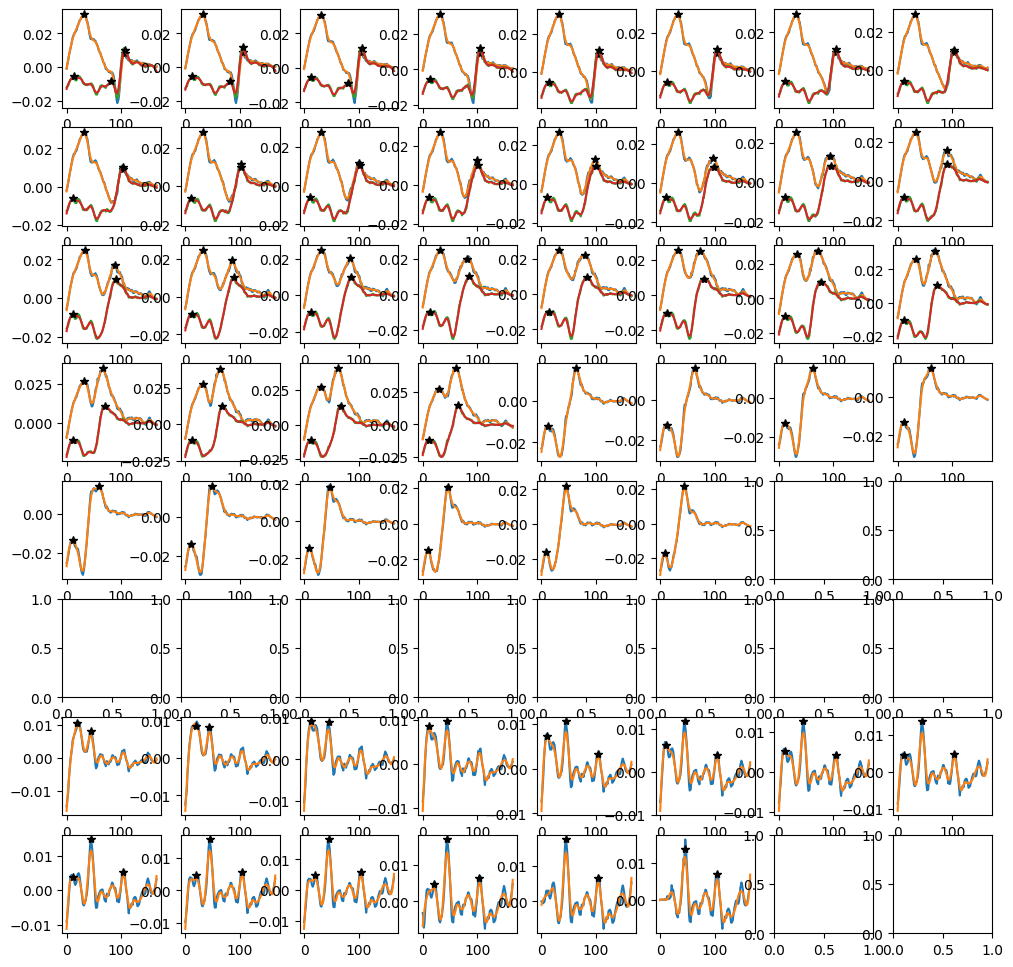

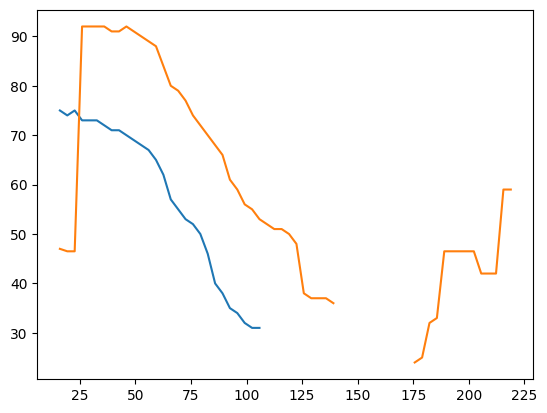

In [129]:
## looking where the peaks are
## you can see multiple peaks and one of the peaks is basically in the same place for the two ratios
from scipy.signal import find_peaks

plt.figure(figsize=(12,12))
Ts = np.zeros((nr,2)) + np.nan
for r in range(nr):
    plt.subplot(8,8,r+1)
    for c in range(2):
        s = wdlkymo_rho[50:,r,c]
        ss = savgol_filter(s, 21, 3)
        pks = find_peaks(ss, prominence=0.005)[0]
        if len(pks)>1:
            T = np.mean(np.diff(pks))
            Ts[r,c] = T
            plt.plot(s)
            plt.plot(ss)
            plt.plot(pks, s[pks], 'k*')

plt.figure()
plt.plot(rs, Ts)

In [ ]:
cf = np.zeros((nt,3))
for t in range(nt):
    tedt = edt[t,:,:]
    for c in range(3):
        tcim = im_all[t,:,:,c+1]
        idx = tedt.max() - tedt < 16
        cf[t,c] = np.nanmean(tcim[idx])

In [ ]:
crho_rc = cf[:,0] / cf[:,2]
crho_yc = cf[:,1] / cf[:,2]
crho_ry = cf[:,0] / cf[:,1]

lcrho_rc = np.log(crho_rc)
lcrho_yc = np.log(crho_yc)
lcrho_ry = np.log(crho_ry)

dlcrho_rc = savgol_filter(lcrho_rc, 21, 3, deriv=1)
dlcrho_yc = savgol_filter(lcrho_yc, 21, 3, deriv=1)
dlcrho_ry = savgol_filter(lcrho_ry, 21, 3, deriv=1)

In [ ]:
plt.plot(dlcrho_rc)
plt.plot(dlcrho_yc)
plt.plot(dlcrho_ry)

In [ ]:
from scipy.integrate import odeint

alpha_r, alpha_c = 1,1
k_r, k_c = 1,1
p = 10
n = 1

ir,ic = np.meshgrid(np.linspace(0,1), np.linspace(0,1))
drhodt = (alpha_r * k_r * ir - alpha_c * k_c * ic) * p**n / (1 + k_r * p**n + k_c * p**n)

In [ ]:
plt.imshow(drhodt)
plt.colorbar()